# Adaptive Boosting (AdaBoost) FOR Face Detection

In [1]:
%matplotlib inline

In [2]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
from dask import delayed
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from data_processing import data
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from scipy.optimize import minimize
from scipy.optimize import fminbound
from sklearn.tree import DecisionTreeClassifier

### Draw Haar Feature

The procedure to extract the Haar-like features from an image is relatively simple. Firstly, a region of interest (ROI) is defined. Secondly, the integral image within this ROI is computed. Finally, the integral image is used to extract the features.

In [3]:
#@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

We use a our project1 dataset which is composed of 1000 face images and 1000 non-face images. Each image has been resized to a ROI of 16 by 16 pixels.We select 2/3 as training set and 1/3 as testing set.

### Data preparation

In [4]:
images = data
# To speed up the example, extract the two types of features only
feature_types = ['type-2-y', 'type-3-x']

# Build a computation graph using Dask. This allows the use of multiple
# CPU cores later during the actual computation
X = delayed(extract_feature_image(img, feature_types) for img in images)
# Compute the result
t_start = time()
X = np.array(X.compute(scheduler='threads'))
time_full_feature_comp = time() - t_start

# Label images (1000 faces and 1000 non-faces)
y = np.array([1] * 500 + [0] * 500)
# Split data, 2/3 training, 1/3 testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=0,
                                                    stratify=None)
# Extract all possible features
feature_coord, feature_type = \
    haar_like_feature_coord(width=images.shape[2], height=images.shape[1],
                            feature_type=feature_types)


Before boosting, we would like to 
1.compute the value of each Harr feature for each sample. Each feature corresponds to a weak learner.(This is already done by extract_feature_image function, X is the feature value)
2.Determine the threshold between face samples and non-face samples for all the weak learners.(check the thetaLis)
3.Calculate the classification error for each weak learner and draw the best ten features(check the errorLis)

### Haar Feature before boosting

In [5]:
thetaLis=[]
errorLis=[]
for k in range(0,X_train.shape[1]):   
    def total(theta):
        val = np.zeros((X_train.shape[0]))
        for i in range(0, X_train.shape[0]):
            if X_train[i,k] < theta:
                val[i] = 0
            else:
                val[i] = 1             
        total = 0
        for j in range (0,val.shape[0]):
            if val[j] == y_train[j]:
                total = total + 0
            else: 
                total = total + 1     
        total = total /val.shape[0] 
        return total
    from scipy.optimize import fminbound
    xmin=fminbound(total,0,0.49,full_output=1)
    thetaLis.append(xmin[0])
    errorLis.append(xmin[1])

In [6]:
np.sort(errorLis)[0:10]

array([0.17761194, 0.17910448, 0.17910448, 0.17910448, 0.18059701,
       0.18208955, 0.18208955, 0.18208955, 0.18358209, 0.18507463])

### Sorted the errorLis, and pick up and plot the best ten features that with minimum classification error, we could use these features for further comparison after the boosting 

In [7]:
#check how many features we extract
X_train.shape[1]

14040

Plot 10 best features before boosting

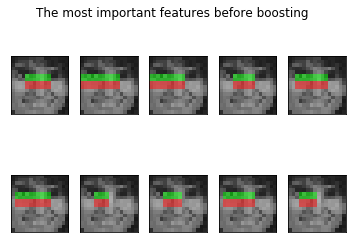

In [8]:
idx_sorted = np.argsort(errorLis)[0:10]
fig, axes = plt.subplots(2, 5)
for idx, ax in enumerate(axes.ravel()):
    image = images[0]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features before boosting')

Next step, we implement Adaboost classifier, get the best 10 features and compare with the one before boosting. Tune the parameters.

### Implement AdaBoost Classfier and draw the best 10 features

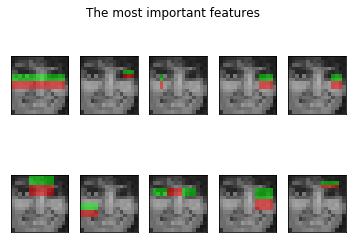

In [25]:
# Train a AdaBoost classifier and assess its performance, assuming we stop with 40 weak-classifi1er
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=40, learning_rate=0.55, algorithm='SAMME', random_state=None)
clf.fit(X_train, y_train)
time_full_train = time() - t_start
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Sort features in order of importance and plot the six most significant
idx_sorted_new = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(2, 5)
for idx, ax in enumerate(axes.ravel()):
    image = images[0]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted_new[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')

check the prdict probability and predict label, conclude the confusion matrix.

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
predict_prob = clf.predict_proba(X_test)[:, 1]
predict_label = clf.predict(X_test)
fpr,tpr,threshold = roc_curve(y_test,predict_prob)
confusion_matrix(y_test, predict_label)

array([[165,   2],
       [  2, 161]], dtype=int64)

Define ROC function and plot ROC curve for final results

### Plot ROC

In [27]:
def ROCcurve(test_data,predict_score):
    print(test_data.shape)
    print(predict_score.shape)
    fpr,tpr,threshold = roc_curve(test_data,predict_score)
    roc_auc = auc(fpr,tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")  

(330,)
(330,)


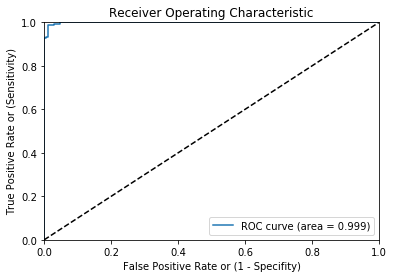

In [28]:
ROCcurve(y_test,predict_prob)

In [29]:
auc_full_features

0.9988244370155395